In [71]:
#This notebook will import a touchstone file and display insertion loss graph.
import pandas as pd
import numpy as np
import matplotlib as plt

# Set the url of the raw .s4p file
url = "https://raw.githubusercontent.com/jayarerita/signal_integrity/master/<cable_data>.s4p"
!wget -O data1.s4p https://raw.githubusercontent.com/jayarerita/signal_integrity/master/cable_data_1.s4p

# This section here is used to read the first 100 rows of the file above as text and 
# parse through each line to find the "#" symbol signifying the start of the data. 
# This can be used to set the number of "skip rows" for read_csv below. We can also pull the information from this
# line to show what the units and format of the data are. For example if row number 24 is "#Hz S dB R 50" then 
# we would set skip_rows = 24, SI_units = "dB", number_type = "real", tester_impedance = "50"

with open("data1.s4p", "r") as file1:
    # Search through the first 100 rows of the file
    for i in range(0, 100):
        # Assign the entire row to a string variable for slicing
        one_line = file1.readline()
        # Search the first character in each successive line for the "#" symbol indicating the key row
        if (one_line[0] == "#"):
            # Set the skip row number for use in the read_csv method later on
            skip_rows = i
            # Set a string variable to the skip row containing the units, number type, and impedance for later use
            key_row = one_line
        
print('The firtst ' + str(skip_rows) + ' rows of the file contain header info and will be skipped.')
print('The s-parameter data is in the format ' + key_row)

--2019-03-20 22:38:15--  https://raw.githubusercontent.com/jayarerita/signal_integrity/master/<cable_data>.s4p
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1426153 (1.4M) [text/plain]
Saving to: ‘data1.s4p’

data1.s4p           100%[===================>]   1.36M  4.63MB/s    in 0.3s    

2019-03-20 22:38:15 (4.63 MB/s) - ‘data1.s4p’ saved [1426153/1426153]

The firtst 20 rows of the file contain header info and will be skipped.
The s-parameter data is in the format # Hz S  dB   R 50



In [72]:
# Read in the space delimited file, skipping the rows of header information. 
# The skip_rows is + 1 because of indexing.
df_raw = pd.read_csv(url, skiprows = skip_rows + 1, delim_whitespace = True, header = None)

df_raw.head(5)

,0,1,2,3,4,5,6,7,8
0,1.000000e+07,-18.596588,25.395187,-0.829325,-18.962502,-20.599869,20.452127,-22.130384,167.08244
1,-8.246641e-01,-18.926477,-19.969500,14.719769,-22.138124,167.045780,-21.730087,6.246666,NaN
2,-2.057517e+01,20.198177,-22.130781,166.885910,-18.240007,27.106436,-0.820171,-18.926466,NaN
3,-2.211367e+01,167.374400,-21.719362,6.261957,-0.831857,-18.954756,-19.607506,17.418802,NaN
4,2.000000e+07,-15.933050,23.195728,-0.907085,-36.680450,-18.317211,22.228508,-22.045498,148.03929


The s4p data comes in an odd format. Each fourth line has 9 elements while the other 3 have 8.  We want to move the 8 elements on line 2,3, and 4 for each group to line up with elements 2-9 in line 1. The empty space left by this move will be filled by null values.

In the loop below we will parse through and reassign every element to an appropriate location in a clean matrix. The new matrix will contain the test frequency in the first column, and the S-parameters in the following 8 columns.

In [73]:
# Make an empty df of the correct size order to replace each index.
df_clean = pd.DataFrame(np.nan, index = range(shape[0]), columns = df_raw.columns)
# Parse through each row
for row in range(df_raw.shape[0]):
    # Parse through each column
    for col in range(df_raw.shape[1]):
        # Set a boolean value to True if it is the 1st, 5th, 9th, etc. line with 9 elements.
        fourth_row = ((row + 1) % 4 == 1)
        # Set a boolean value to True if it is the 1st column.
        first_col = (col == 0)
        # print('row: ' + str(row) + " col: " + str(col) + " fourth_row: " + str(fourth_row) + ' first_col: ' + str(first_col))
        if (fourth_row and first_col):
            # Assign the test frequency to the first column. This is only run on the first of every
            # four rows. 
            df_clean.iloc[row, col] = df_raw.iloc[row, col]
            # Reset the test frequency value.
            freq = df_raw.iloc[row,0]
        elif (first_col):
            # Assign the test frequency to the first column if not already there.This occurs on 
            # rows 2, 3, 4 in a set.
            df_clean.iloc[row,0] = freq
        elif (fourth_row):
            # Asign the corresponding value in the raw df to the clean df
            df_clean.iloc[row,col] = df_raw.iloc[row, col]
        else:
            # Assign the value from the preceeding column index in the raw df to the current
            # one in the clean df. This essentially shifts all the values in the row over one.
            df_clean.iloc[row,col] = df_raw.iloc[row, col - 1]
            

In [74]:
# Assign new column headers to help with dropping columns later
df_clean.columns = ['Freq', '1', 'i1', '2', 'i2', '3', 'i3', '4', 'i4']

# Display the df as a check
df_clean.head(10)



,Freq,1,i1,2,i2,3,i3,4,i4
0,10000000.0,-18.596588,25.395187,-0.829325,-18.962502,-20.599869,20.452127,-22.130384,167.082440
1,10000000.0,-0.824664,-18.926477,-19.969500,14.719769,-22.138124,167.045780,-21.730087,6.246666
2,10000000.0,-20.575172,20.198177,-22.130781,166.885910,-18.240007,27.106436,-0.820171,-18.926466
3,10000000.0,-22.113672,167.374400,-21.719362,6.261957,-0.831857,-18.954756,-19.607506,17.418802
4,20000000.0,-15.933050,23.195728,-0.907085,-36.680450,-18.317211,22.228508,-22.045498,148.039290
5,20000000.0,-0.894979,-36.679436,-18.318392,12.131729,-22.075417,147.892270,-21.316929,5.653028
6,20000000.0,-18.289541,22.242695,-22.057865,147.862060,-15.512713,24.817228,-0.905958,-36.740604
7,20000000.0,-22.017279,148.079270,-21.319891,5.571363,-0.915962,-36.726948,-17.741117,15.174589
8,30000000.0,-14.164801,15.447616,-0.949940,-54.491714,-16.506487,16.863007,-21.879795,129.671130
9,30000000.0,-0.939659,-54.502537,-17.243998,6.663044,-21.932217,129.327580,-20.788912,4.192590


In [75]:
# Drop the imaginary columns, i1,i2, i3, i4
df_clean.drop(['i1', 'i2', 'i3', 'i4'], axis = 1, inplace = True)

# Preview the clean data
df_clean.head(5)
            

,Freq,1,2,3,4
0,10000000.0,-18.596588,-0.829325,-20.599869,-22.130384
1,10000000.0,-0.824664,-19.969500,-22.138124,-21.730087
2,10000000.0,-20.575172,-22.130781,-18.240007,-0.820171
3,10000000.0,-22.113672,-21.719362,-0.831857,-19.607506
4,20000000.0,-15.933050,-0.907085,-18.317211,-22.045498


In [76]:
# Now we can create a df with just the insertion loss data by dropping columns 2,3,4 
# and every 1st, 3rd, and 4th row.

df_IL = df_clean.copy()

df_IL.drop(['2', '3', '4'], axis = 1, inplace = True)

for row in range(df_IL.shape[0]):
    if (not(row + 3) % 4 == 0):
        df_IL.drop(row, axis = 0, inplace = True)
        
df_IL.columns = ['Freq','SDD21']
df_IL.head(10)



,Freq,SDD21
1,10000000.0,-0.824664
5,20000000.0,-0.894979
9,30000000.0,-0.939659
13,40000000.0,-0.973613
17,50000000.0,-1.002662
21,60000000.0,-1.011892
25,70000000.0,-1.018019
29,80000000.0,-1.010053
33,90000000.0,-1.010594
37,100000000.0,-1.015874


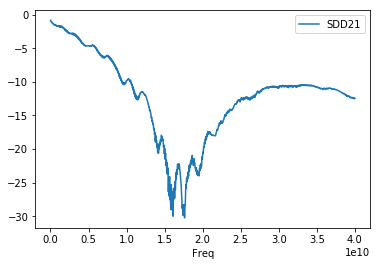

In [77]:
# Allow inline plotting for the notebook
%matplotlib inline

# Create a simple line plot of the data
df_IL.plot(x = 'Freq', y = 'SDD21', kind = 'line')